# Data augmentation

Como hemos visto, la cantidad de datos que se le dan a una red es algo importantísimo. Cuantos más datos distintos tenga la red para aprender, mejor hará su trabajo. Pero hay veces que tenemos una cantidad de datos determinada y no podemos tener más, así que una técnica para hacer como que tenemos más datos es el *data augmentation*

Supongamos que tenemos la siguiente imagen

![lobo](Imagenes/Lobo.jpg)

Si se la metemos muchas veces a la red, esta al final se la acaba aprendiendo, pero qué pasa si le metemos esta imagen?

![lobo mirror](Imagenes/Lobo_mirror.jpg)

Y si le metemos esta?

![lobo zoom](Imagenes/Lobo_zoom.jpg)

Para nosotros es siempre el mismo lobo, pero para la red neuronal no. La red neuronal solo ve una matriz, por lo que a no ser que se le meta siempre la misma matriz, en la que todos los píxeles valen igual, para la red será una imagen diferente.

¿Y esto en qué nos beneficia?

Como hemos dicho en darle a la red muchos más datos para poder entrenar. Pero no solo eso, sino datos distintos, porque en la imagen en la que el lobo sale con zoom, no se ve el cuerpo entero del lobo. Por lo que si la red había aprendido que un lobo es una animal con cuatro patas, cuerpo, cabeza y cola, en este caso que no se le ve todo eso, tiene que aprender otros patrones para saber si es un lobo o no. Lo cual hace a la red más robusta.

## Data augmentation con Pytorch

Para ver cómo se hace data augmentation con Pytorch, primero vamos a vrear una función a la que le entra una lista de imágenes y las representa

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision.transforms as T


orig_img = Image.open('Imagenes/Lobo.jpg')
torch.manual_seed(0)


def plot(imgs, with_orig=True, **kwargs):
    num_rows = 1
    num_cols = len(imgs)
    if with_orig:
        num_cols += 1
        imgs = [orig_img] + imgs
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 12))
    for col_idx, img in enumerate(imgs):
        ax = axs[col_idx]
        ax.imshow(np.asarray(img), **kwargs)
        ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0].set(title='Original image')
        axs[0].title.set_size(8)

    plt.show()

Ahora que tenemos la función, empezamos con la transformación de imágenes. En la página [transforms](https://pytorch.org/vision/stable/transforms.html) de Pytorch vienen explicadas todas las posibles trasnformaciones que se pueden hacer.

A continuación vamos a ver unas cuantas

Por ejemplo, si queremos añadir un padding a una imagen podemos usar el transformador [pad](https://pytorch.org/vision/stable/generated/torchvision.transforms.Pad.html#torchvision.transforms.Pad), donde se le indica la cantidad de píxeles de padding que se quiere añadir

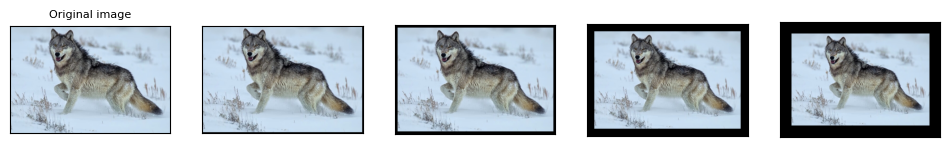

In [2]:
padded_imgs = [T.Pad(padding=padding)(orig_img) for padding in (3, 10, 30, 50)]
plot(padded_imgs)

Si queremos redimensionar la imagen podemos usar [resize](https://pytorch.org/vision/stable/generated/torchvision.transforms.functional.resize.html#torchvision.transforms.functional.resize), donde le podemos pasar una tupla con el tamaño de la imagen, o un entero con el porcentaje del tamaño de la imagen original

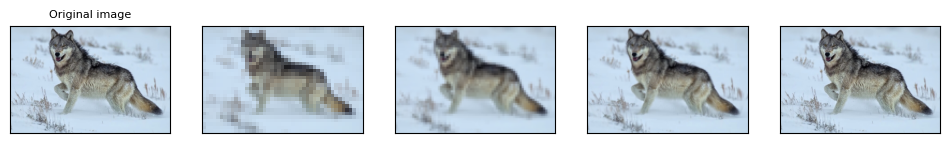

In [3]:
resized_imgs = [T.Resize(size=size)(orig_img) for size in (30, 50, 100, (orig_img.size[1], orig_img.size[0]))]
plot(resized_imgs)

Podemos hacer un recorte del centro de la imagen mediante [CenterCrop](https://pytorch.org/vision/stable/generated/torchvision.transforms.CenterCrop.html#torchvision.transforms.CenterCrop) donde se le indica la cantidad de píxeles que va a tener el recorte, tanto con un número entero, como con una tupla con el tamaño

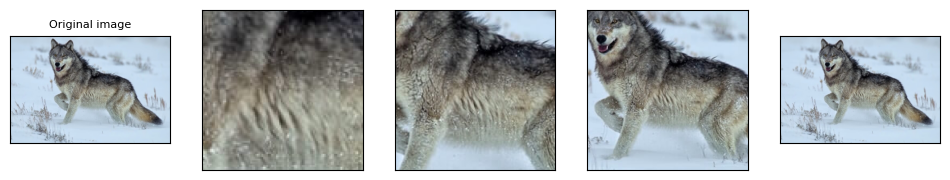

In [4]:
center_crops = [T.CenterCrop(size=size)(orig_img) for size in (100, 200, 300, (orig_img.size[1], orig_img.size[0]))]
plot(center_crops)

Podemos convertir a blanco y negro una imagen con [Grayscale](https://pytorch.org/vision/stable/generated/torchvision.transforms.Grayscale.html#torchvision.transforms.Grayscale)

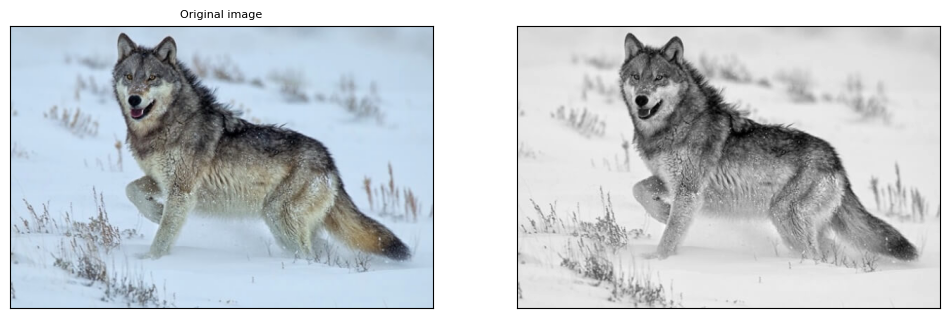

In [5]:
gray_img = T.Grayscale()(orig_img)
plot([gray_img], cmap='gray')

Podemos cambiar el brillo, contraste, saturación y el tono de una imagen con [ColorJitter](https://pytorch.org/vision/stable/generated/torchvision.transforms.ColorJitter.html#torchvision.transforms.ColorJitter)

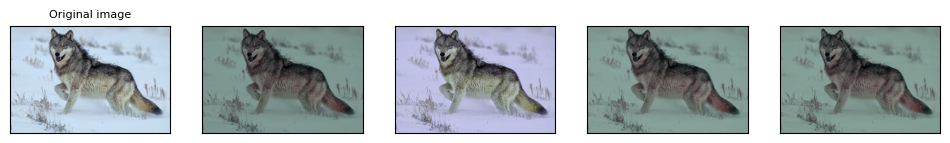

In [6]:
jitter = T.ColorJitter(brightness=.5, hue=.3)
jitted_imgs = [jitter(orig_img) for _ in range(4)]
plot(jitted_imgs)

Podemos cambiar la perspectiva de una imagen con [RandomPerspective](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomPerspective.html#torchvision.transforms.RandomPerspective)

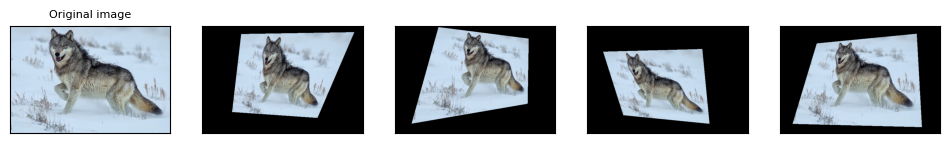

In [7]:
perspective_transformer = T.RandomPerspective(distortion_scale=0.6, p=1.0)
perspective_imgs = [perspective_transformer(orig_img) for _ in range(4)]
plot(perspective_imgs)

Podemos rotar aleatoriamente una imagen con [RandomRotation](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomRotation.html#torchvision.transforms.RandomRotation)

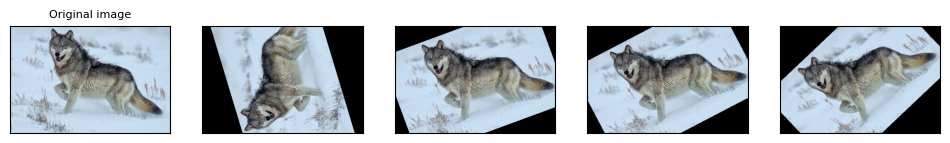

In [8]:
rotater = T.RandomRotation(degrees=(0, 180))
rotated_imgs = [rotater(orig_img) for _ in range(4)]
plot(rotated_imgs)

Podemos voltear la imagen vertical y horizontalmente de manera aleatoria con [RandomHorizontalFlip](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomHorizontalFlip.html#torchvision.transforms.RandomHorizontalFlip) y [RandomVerticalFlip](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomVerticalFlip.html#torchvision.transforms.RandomVerticalFlip)

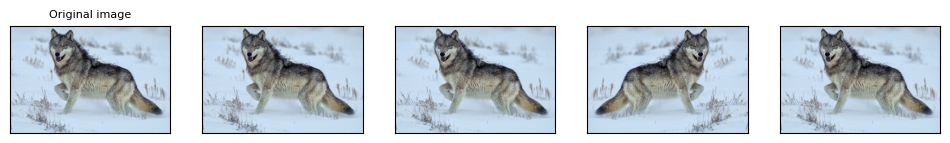

In [9]:
hflipper = T.RandomHorizontalFlip(p=0.5)
transformed_imgs = [hflipper(orig_img) for _ in range(4)]
plot(transformed_imgs)

## Varios data augmentation a una imagen

A la hora de entrenar una red no se le hace una única transformación a la imagen, se le suelen hacer varias de manera aleatoria, es decir, con una determinada probabilidad para cada transformación. Así en una época, la red podría ver la foto del lobo con un cierto zoom, una rotación aleatoria, un posible volteo vertical u horizontal, etc

Para eso Pytorch nos hace encadenar las transformaciones como si fuera un conjunto secuencial

``` python
transforms = torch.nn.Sequential(
    T.RandomCrop(224),
    T.RandomHorizontalFlip(p=0.3),
)
```

Como cuando definíamos una red neuronal desde cero

En este caso se hará un recorte aleatorio de la imagen de 224x224 píxeles y se volteará la imagen verticalmente con una probabilidad del 30%

Así que vamos a crear una secuencia de transformaciones con todas las que hemos visto antes

In [10]:
transforms = torch.nn.Sequential(
    T.Resize(size=(224, 224)),                                                  # Resize to 224x224
    T.Pad(padding=(0, 10, 30, 50)),                                             # Random padding between 0, 3, 10, 30, 50
    T.CenterCrop(size=((300,300))),                                             # Random center crop between 0, 100, 200, 300
    T.Grayscale(),                                                              # Convert to grayscale
    T.ColorJitter(brightness=.5, hue=.3),                                       # Random color jitter
    T.RandomPerspective(distortion_scale=0.6, p=1.0),                           # Random perspective
    T.RandomRotation(degrees=(0, 180)),                                         # Random rotation between 0 and 180 degrees
    T.RandomHorizontalFlip(p=0.5),                                              # Random horizontal flip
    T.RandomVerticalFlip(p=0.5)                                                 # Random vertical flip
)

Realizamos cuatro transformaciones sobre la imagen

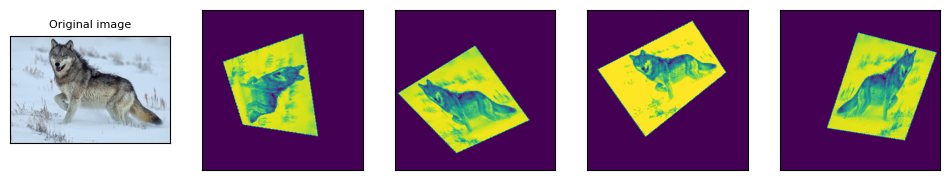

In [11]:
transformed_imgs = [transforms(orig_img) for _ in range(4)]
plot(transformed_imgs)

Si volvemos a realizar la transformación no volvemos a obtener las mismas imágenes

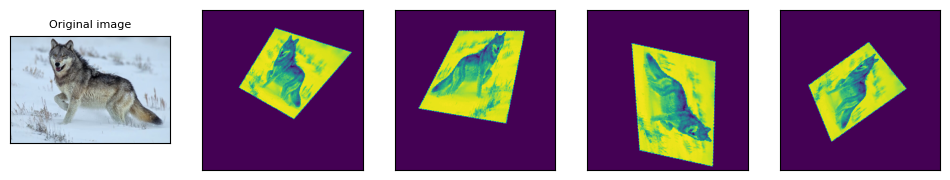

In [12]:
transformed_imgs = [transforms(orig_img) for _ in range(4)]
plot(transformed_imgs)

Esto es lo mismo que pasaría al entrenar, en cada época se realizarían unas transformaciones aleatorias y no siempre las mismas

## Entrenamiento de una red con data augmentation

A la hora de entrenar una red neuronal aplicando data augmentation, el código casi no cambia, excepto a la hora de definir el `Dataset`, donde definimos las transformaciones

Vamos a entrenar el clasificador entre perros y gatos que hemos visto hasta ahora y cuando lleguemos a la definición del `Dataset` veremos como definir las transformaciones

### Dataframe

Realizamos la misma limpieza que en los notebooks anteriores

In [13]:
import os
import pandas as pd
import cv2

df_cats = pd.DataFrame({'path': [os.path.join('data/cats_vs_dogs/PetImages/Cat', x) for x in os.listdir('data/cats_vs_dogs/PetImages/Cat')]})
df_cats['label'] = 0
df_cats['type'] = df_cats['path'].apply(lambda x: type(cv2.imread(x)))
df_cats = df_cats[df_cats.type != type(None)]

df_dogs = pd.DataFrame({'path': [os.path.join('data/cats_vs_dogs/PetImages/Dog', x) for x in os.listdir('data/cats_vs_dogs/PetImages/Dog')]})
df_dogs['label'] = 1
df_dogs['type'] = df_dogs['path'].apply(lambda x: type(cv2.imread(x)))
df_dogs = df_dogs[df_dogs.type != type(None)]

df = pd.concat([df_cats, df_dogs], axis=0).reset_index(drop=True)
df = df.sample(frac=1).reset_index(drop=True)   # suffle df
df['height'] = df['path'].apply(lambda x: cv2.imread(x).shape[0])
df['width'] = df['path'].apply(lambda x: cv2.imread(x).shape[1])

df.head()

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0

,path,label,type,height,width
0,data/cats_vs_dogs/PetImages/Cat/11788.jpg,0,<class 'numpy.ndarray'>,297,321
1,data/cats_vs_dogs/PetImages/Cat/7762.jpg,0,<class 'numpy.ndarray'>,273,371
2,data/cats_vs_dogs/PetImages/Cat/2683.jpg,0,<class 'numpy.ndarray'>,240,320
3,data/cats_vs_dogs/PetImages/Dog/6099.jpg,1,<class 'numpy.ndarray'>,500,368
4,data/cats_vs_dogs/PetImages/Dog/5033.jpg,1,<class 'numpy.ndarray'>,377,500


In [14]:
median_shape = (int(df.height.median()), int(df.width.median()))
classes = {'cat': 0, 'dog': 1}

### Dataset

Aquí es donde definimos las transformaciones

In [15]:
import torch
from PIL import Image

import torch
import torchvision.transforms as T

class DatasetCatsDogs(torch.utils.data.Dataset):
    def __init__(self, df, data_augmentation=False):
        self.df = df
        self.data_augmentation = data_augmentation
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]
        self.transforms = T.Compose([
            T.ToTensor(),
            torch.nn.Sequential(
                T.Resize(median_shape, antialias=True),
                T.RandomHorizontalFlip(p=0.5),
                T.RandomRotation(degrees=15),
                T.Normalize(self.mean, self.std)
            ),
        ])
        self.transforms_no_augment = T.Compose([
            T.ToTensor(),
            torch.nn.Sequential(
                T.Resize(median_shape, antialias=True),
                T.Normalize(self.mean, self.std)
            ),
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_cv = cv2.imread(self.df.iloc[idx, 0])  # Read image
        img_cv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        img = Image.fromarray(img_cv)  # Convert from numpy array to PIL image
        if self.data_augmentation:
            img = self.transforms(img)  # Apply transformations if data augmentation is True
        else:
            img = self.transforms_no_augment(img)  # Apply transformations without data augmentation
        label = self.df.loc[idx, 'label']
        return img, label

Aquí hemos definido dos tipos de transformaciones, la que no aplica data augmentation, que solo hace el resize de la imagen, la normaliza y la convierte a tensor, y la que si aplica data augmentation, que a parte de lo anterior, además realiza un volteo horizonta aleatorio (con una probabilidad del 50%) y una rotación aleatoria entre 0º y 15º

Además de eso, ya no leemos la imagen con opencv, sino con PIL, ya que Pytorch, para hacer las transformaciones, espera imágenes de tipo PIL

In [16]:
from sklearn.model_selection import train_test_split

train_split, val_split = train_test_split(df, test_size=0.2, shuffle=True, random_state=42, stratify=df['label'])
# Reset index
train_split = train_split.reset_index(drop=True)
val_split = val_split.reset_index(drop=True)
dataset = {
    'train': DatasetCatsDogs(train_split, data_augmentation=True),
    'val': DatasetCatsDogs(val_split),
}

print(f"Había {len(df)} imágenes en el dataset, lo hemos dividido en {len(dataset['train'])} imágenes de entrenamiento y {len(dataset['val'])} imágenes de validación")

Había 24946 imágenes en el dataset, lo hemos dividido en 19956 imágenes de entrenamiento y 4990 imágenes de validación


Podemos ver que en el dataset de entrenamiento indicamos que sí queremos data augmentation mediante `data_augmentation=True`

Vemos una muestra

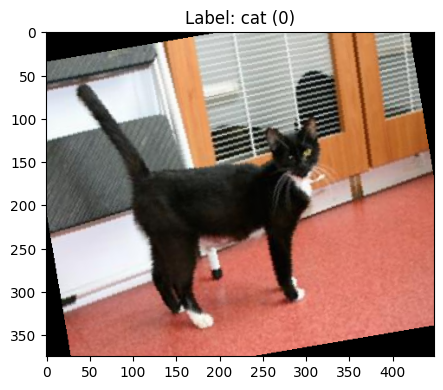

(375, 448, 3)


In [17]:
import numpy as np
import matplotlib.pyplot as plt

idx = np.random.randint(0, len(dataset['train']))
sample_img, sample_label = dataset['train'][idx]

key = [k for k, v in classes.items() if v == sample_label][0]
fig = plt.figure(figsize=(5, 5))
img = sample_img.permute(1, 2, 0).numpy()
img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]) # Unnormalize image
img = np.clip(img, 0, 1)    # Clip values to [0, 1]
plt.imshow(img)
plt.title(f"Label: {key} ({sample_label})")
plt.show()
print(img.shape)

A partir de aquí, el resto del código es igual

### Dataloaders

In [18]:
BS_train = 8
BS_test = 8

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=BS_train, shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=BS_test, shuffle=False, num_workers=4),
}

In [19]:
batch_img, batch_label = next(iter(dataloader['train']))
print(batch_img.shape)

torch.Size([8, 3, 375, 448])


In [20]:
batch_img, batch_label = next(iter(dataloader['train']))
print(batch_img.shape)

torch.Size([8, 3, 375, 448])


### Model

In [21]:
from torchvision.models import resnet50, ResNet50_Weights

num_clases = len(classes)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = resnet50(weights=ResNet50_Weights.DEFAULT)
model.fc = torch.nn.Linear(model.fc.in_features, num_clases)
model = model.to(device)

### Entrenamiento

In [22]:
LR = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

In [23]:
num_prints = 2

def train_loop(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    mul = 1
    model.train()
    mean_loss = 0
    num_batches = len(dataloader)

    for batch, (X, y) in enumerate(dataloader):
        # X and y to device
        X, y = X.to(device), y.to(device)

        # Compute prediction and loss
        preds = model(X)
        loss = loss_fn(preds, y)
        mean_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (batch+1) % int(len(dataloader)/num_prints) == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            mul += 1
    
    return mean_loss/num_batches


def val_loop(dataloader, model, loss_fn, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, correct = 0, 0
    model.eval()

    with torch.no_grad():
        for X, y in dataloader:
            # X and y to device
            X, y = X.to(device), y.to(device)
            
            preds = model(X)
            val_loss += loss_fn(preds, y).item()
            correct += (preds.argmax(1) == y).type(torch.float).sum().item()

    val_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {val_loss:>8f} \n")

    return val_loss, correct

In [24]:
epochs = 12
losses_train_freeze = []
losses_val_freeze = []
accuracies_val_freeze = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    mean_loss =  train_loop(dataloader['train'], model, loss_fn, optimizer, device)
    losses_train_freeze.append(mean_loss)
    mean_loss, accuracy = val_loop(dataloader['val'], model, loss_fn, device)
    losses_val_freeze.append(mean_loss)
    accuracies_val_freeze.append(accuracy)
print("Done!")

Epoch 1
-------------------------------


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


loss: 0.470816  [ 9968/19956]


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9


loss: 0.274378  [19944/19956]


Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 91.3%, Avg loss: 0.208203 

Epoch 2
-------------------------------


Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


loss: 0.263957  [ 9968/19956]


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


loss: 0.232009  [19944/19956]


Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 91.7%, Avg loss: 0.190597 

Epoch 3
-------------------------------


Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


loss: 0.065583  [ 9968/19956]


Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9


loss: 0.095689  [19944/19956]


Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 93.4%, Avg loss: 0.156491 

Epoch 4
-------------------------------


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


loss: 0.193685  [ 9968/19956]


Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9


loss: 0.013535  [19944/19956]


Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 94.6%, Avg loss: 0.134507 

Epoch 5
-------------------------------


Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


loss: 0.305807  [ 9968/19956]


Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


loss: 0.197737  [19944/19956]


Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 94.5%, Avg loss: 0.132671 

Epoch 6
-------------------------------


Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


loss: 0.288492  [ 9968/19956]


Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


loss: 0.017329  [19944/19956]


Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 93.9%, Avg loss: 0.147851 

Epoch 7
-------------------------------


Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


loss: 0.136430  [ 9968/19956]


Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


loss: 0.076349  [19944/19956]


Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 95.4%, Avg loss: 0.116618 

Epoch 8
-------------------------------


Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


loss: 0.007372  [ 9968/19956]


Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9


loss: 0.020188  [19944/19956]


Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 94.9%, Avg loss: 0.118192 

Epoch 9
-------------------------------


Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9


loss: 0.336999  [ 9968/19956]


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9


loss: 0.245399  [19944/19956]


Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 94.7%, Avg loss: 0.139512 

Epoch 10
-------------------------------


Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


loss: 0.469931  [ 9968/19956]


Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


loss: 0.124240  [19944/19956]


Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 95.8%, Avg loss: 0.101634 

Epoch 11
-------------------------------


Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9


loss: 0.216582  [ 9968/19956]


Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


loss: 0.502509  [19944/19956]


Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 94.9%, Avg loss: 0.129702 

Epoch 12
-------------------------------


Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


loss: 0.086320  [ 9968/19956]


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


loss: 0.062177  [19944/19956]


Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 96.1%, Avg loss: 0.099131 

Done!
